In [1]:
#---------------------------------------------------------
# DO NOT MODIFY THIS FILE
# RUN THIS FILE AS IT IS USING THE RUN BUTTON ON THE LEFT
#---------------------------------------------------------

import numpy as np

#this mimics the behavior of set_diff in MATLAB
def set_diff(input_set,elements):
    output = input_set.copy()
    if isinstance(elements, list):
        for element in elements:
            if element in output:
                output.remove(element)
    else:
        output.remove(elements)
    if len(output) == 1:
        output = output[0]
    return output

def set_intersection(set_1,set_2):
    output = list(set(set_1).intersection(set_2))
    if len(output) == 1:
        output = output[0]
    return output

def link_length_difference(dx,
                           dt,
                           node_positions,
                           non_ground_links_idx,
                           connectivity_matrix,
                           link_lengths,
                           non_fixed_nodes,
                           sliders,
                           links_with_fixed_angle,
                           link_fixed_angles,
                           crank_angular_velocity,
                           initial_node_positions,
                           motor_node_idx,
                           crank_tip_node_idx,
                           rotation_fixed_nodes,
                           rotation_fixed_nodes_vectors):
    #outputs the square difference between current link lengths and constrained link lengths
    #dx=[x1 x2 x3.... y1 y2 y3.....] %How to format dx| by breaking complex into x and y components

    length_difference = [] #initialize length difference
    node_positions_temp = node_positions.copy() #Copy to temp
    length_dx = len(non_fixed_nodes)*2

    #Allocation of objective function contributions from slider constraints
    slider_DOF = 0
    for slider in sliders:
     if slider[1]==4:
        slider_DOF = slider_DOF+1 # Middle node positon contribution to objective function
     elif slider[1]==3:
        slider_DOF = slider_DOF+2 # Middle node position and length of links that make slider

    slider_difference = []

    for i,non_fixed_node in enumerate(non_fixed_nodes): #loop through non-fixed nodes
        node_positions_temp[non_fixed_node] = node_positions_temp[non_fixed_node] + dx[i]  #Adds the perturbation dx to the copy
        node_positions_temp[non_fixed_node] = node_positions_temp[non_fixed_node] + dx[int(length_dx/2)+i]*1j #Adds the perturbation dx to the copy


    for link_idx in non_ground_links_idx: #loop over links that are being readjusted
        delta = node_positions_temp[connectivity_matrix[link_idx][0]]-node_positions_temp[connectivity_matrix[link_idx][1]]
        length_difference.append(np.linalg.norm(delta)-link_lengths[link_idx]) #computes the length difference

    #Modifies dx for the slider joints according to sliding direction
    if len(sliders)>0:
        for slider in sliders:
            #If moving slider
            if len(slider)==3:
                node_1_idx = set_diff(connectivity_matrix[slider[1]],slider[0])
                node_2_idx = set_diff(connectivity_matrix[slider[2]],slider[0])

                #Calculates the distance from the line (2 slider endpoints) that the middle node is
                y2my1 = np.imag(node_positions_temp[node_2_idx]-node_positions_temp[node_1_idx])
                x2mx1 = np.real(node_positions_temp[node_2_idx]-node_positions_temp[node_1_idx])
                x2y1 = np.real(node_positions_temp[node_2_idx])*np.imag(node_positions_temp[node_1_idx])
                y2x1 = np.imag(node_positions_temp[node_2_idx])*np.real(node_positions_temp[node_1_idx])
                numerator = abs(y2my1*np.real(node_positions_temp[slider[0]])-x2mx1*np.imag(node_positions_temp[slider[0]])+x2y1-y2x1)
                denominator = np.sqrt(y2my1**2+x2mx1**2)
                slider_difference.append((numerator/denominator)) #Adds objective function contribution for distance middle slider node is from slider line

                # Adds objective function contribution to limit the length of the two slider links to the original combined length
                slider_difference.append(np.linalg.norm(node_positions_temp[node_2_idx]-node_positions_temp[node_1_idx])-(link_lengths[slider[1]]+link_lengths[slider[2]]))

            #If fixed slider
            if len(slider)==4:
                y2my1=slider[3]
                x2mx1=slider[2]
                x2y1=(slider[2]+np.real(initial_node_positions[slider[0]]))*np.imag(initial_node_positions[slider[0]])
                y2x1=(slider[3]+np.imag(initial_node_positions[slider[0]]))*np.real(initial_node_positions[slider[0]])
                numerator=abs(y2my1*np.real(node_positions_temp[slider[0]])-x2mx1*np.imag(node_positions_temp[slider[0]])+x2y1-y2x1)
                denominator=np.sqrt(y2my1**2+x2mx1**2)
                slider_difference.append((numerator/denominator)) #Adds objective function contribution for distance middle slider node is from slider line


    #Creates objective function contributions for fixed angle constraints
    #Calculates the difference in angle at fixed angle locations between adjustments
    angle_difference = []
    if len(link_fixed_angles)>0:
        for fixed_angle_idx,link_with_fixed_angle in enumerate(links_with_fixed_angle):
            common_node_idx = set_intersection(connectivity_matrix[link_with_fixed_angle[1]],connectivity_matrix[link_with_fixed_angle[0]])
            link_1_node_idx = set_diff(connectivity_matrix[link_with_fixed_angle[0]],common_node_idx)
            link_1_vec =  node_positions_temp[link_1_node_idx] - node_positions_temp[common_node_idx]

            link_2_node_idx = set_diff(connectivity_matrix[link_with_fixed_angle[1]],common_node_idx)
            link_2_vec = node_positions_temp[link_2_node_idx] - node_positions_temp[common_node_idx]
            new_angle = (np.real(link_1_vec)*np.real(link_2_vec)+np.imag(link_1_vec)*np.imag(link_2_vec))/(np.linalg.norm(link_1_vec)*np.linalg.norm(link_2_vec))
            angle_difference.append(link_fixed_angles[fixed_angle_idx]-new_angle)

    #Creates objective function contributions for rotation fixed constraints
    #Calculates the difference in angle at for each vector at a fixed rotation location between adjustments
    rotation_fixed_nodes_difference = []
    if len(rotation_fixed_nodes)>0:
        for rotation_fixed_node_idx,rotation_fixed_node in enumerate(rotation_fixed_nodes):
            links_with_rotation_fixed_nodes,node_idx=np.where(np.array(connectivity_matrix)==rotation_fixed_node)
            for link_idx,link in enumerate(links_with_rotation_fixed_nodes):
                    non_rotation_fixed_node=connectivity_matrix[link][1-node_idx[link_idx]]
                    new_rotation_fixed_node_vector = node_positions_temp[non_rotation_fixed_node]-node_positions_temp[rotation_fixed_node]
                    old_rotation_fixed_node_vector = rotation_fixed_nodes_vectors[rotation_fixed_node_idx][link_idx]
                    rotation_fixed_angle_difference = 1-(np.real(new_rotation_fixed_node_vector)*np.real(old_rotation_fixed_node_vector)+np.imag(new_rotation_fixed_node_vector)*np.imag(old_rotation_fixed_node_vector))/(np.linalg.norm(new_rotation_fixed_node_vector)*np.linalg.norm(old_rotation_fixed_node_vector))
                    rotation_fixed_nodes_difference.append(rotation_fixed_angle_difference)

    #Create total difference array
    total_difference_array = length_difference + slider_difference + angle_difference + rotation_fixed_nodes_difference

    #Add objective function contribution for angular velocity of crank.
    #Calculates the angular velocity difference between adjustments to match prescribed angular velocity
    new_crank_vector = node_positions_temp[crank_tip_node_idx]-node_positions_temp[motor_node_idx]
    old_crank_vector = node_positions[crank_tip_node_idx]-node_positions[motor_node_idx]
    perpdot = np.real(old_crank_vector)*np.imag(new_crank_vector) - np.imag(old_crank_vector)*np.real(new_crank_vector)
    change_in_angle = np.arcsin(perpdot/(np.linalg.norm(old_crank_vector)*np.linalg.norm(new_crank_vector)))*180/np.pi
    angular_velocity_difference = ((change_in_angle/dt)-crank_angular_velocity)
    total_difference_array.append(angular_velocity_difference)
    return np.array(total_difference_array)

In [2]:
#---------------------------------------------------------
# DO NOT MODIFY THIS FILE
# RUN THIS FILE AS IT IS USING THE RUN BUTTON ON THE LEFT
#---------------------------------------------------------

#|Numerical PVA Code|University of Illinois at Urbana-Champaign|
#|ME 370|Created by Brian C. McGuigan for MATLAB adapted by Ali Ibrahim A Albazroun for Python

#Section0:Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from scipy.optimize import least_squares
from functools import partial
from IPython.display import HTML
import matplotlib.animation as animation
#from linklen import (link_length_difference,set_diff,set_intersection)

def PVA(
    initial_node_positions,
    connectivity_matrix,
    ground_links_idx,
    crank_link_idx,
    motor_node_idx,
    sliders,
    links_with_fixed_angle,
    rotation_fixed_nodes,
    tperiod,
    dt,
    crank_angular_velocity,
    plotting_node_idx,
):

    n_timesteps=int(tperiod/dt) #Total number of timesteps
    time= np.linspace(0,tperiod,n_timesteps) #array holding the amount of time that has passed

    #Section 2: Useful information about the sytem
    ground_links = []
    for ground_link_idx in ground_links_idx:
        ground_links += connectivity_matrix[ground_link_idx]
    ground_link_nodes = list(set(ground_links)) #this removes duplicate nodes

    fixed_nodes = ground_link_nodes.copy()
    for slider in sliders:
        if slider[0] in fixed_nodes:
            fixed_nodes.remove(slider[0])

    non_fixed_nodes = list(range(len(initial_node_positions))) #Nodes without prescribed/fixed placement (the ones that can vary after we move crank link a bit)
    if len(fixed_nodes)>0:
        non_fixed_nodes = set_diff(non_fixed_nodes,fixed_nodes) #remove fixed nodes
    crank_tip_node_idx = set_diff(connectivity_matrix[crank_link_idx],motor_node_idx) #Node index denoting the tip of the input crank link

    n_DOF=len(non_fixed_nodes)*2
    non_ground_links_idx = set_diff(list(range(len(connectivity_matrix))),ground_link_idx) #links that may have varying lengths after a timestep

    #Slider information used for DFA
    slider_links=[]
    slider_end_nodes=[]
    for slider_idx,slider in enumerate(sliders):
        if slider[1] in non_ground_links_idx:
            non_ground_links_idx.remove(slider[1])
        if len(slider)==3:
            non_ground_links_idx.remove(slider[2])
            slider_links.append([slider_idx,slider[1], slider[2]]) #total list of all slider links [slider_index, link1_index, link2_index]
            common_node= set_intersection(connectivity_matrix[slider[1]],connectivity_matrix[slider[2]])
            end_nodes = set_diff(set(connectivity_matrix[slider[1]] + connectivity_matrix[slider[2]]),common_node)
            slider_end_nodes.append(end_nodes)


    #Section 3: Allocation/Initialization
    node_positions = np.zeros((initial_node_positions.shape[0],n_timesteps),dtype=np.complex128) #allocate node positions over all time steps
    node_positions[:,0] = initial_node_positions #Initialize current timestep (put in initial node position data)

    #Section 4: Put in initial fixed ground link nodes positions at each time step in corresponding position array since they are fixed
    for i in range(1,n_timesteps):
        node_positions[ground_link_nodes,i] = initial_node_positions[ground_link_nodes]

    #Section 6: Computes link lengths from initial node positions
    link_lengths=np.zeros((len(connectivity_matrix),)) #Allocate array for link lengths

    for link_idx,link_nodes in enumerate(connectivity_matrix): #loop over connectivity matrix
        delta = initial_node_positions[link_nodes[1]]-initial_node_positions[link_nodes[0]]
        link_lengths[link_idx] = np.linalg.norm(delta) #compute length between nodes

    #Compute initial link angle for fixed angle constraint
    link_fixed_angles= []
    rotation_fixed_nodes_vectors = {}

    #Calculates the initial angles for the fixed angle constraints
    for fixed_angle_idx,link_with_fixed_angle in enumerate(links_with_fixed_angle):
        common_node_idx = set_intersection(connectivity_matrix[link_with_fixed_angle[1]],connectivity_matrix[link_with_fixed_angle[0]])
        link_1_node_idx = set_diff(connectivity_matrix[link_with_fixed_angle[0]],common_node_idx)
        link_1_vec = initial_node_positions[link_1_node_idx]-initial_node_positions[common_node_idx]

        link_2_node_idx = set_diff(connectivity_matrix[link_with_fixed_angle[1]],common_node_idx)
        link_2_vec = initial_node_positions[link_2_node_idx]-initial_node_positions[common_node_idx]
        link_fixed_angles.append((np.real(link_1_vec)*np.real(link_2_vec)+np.imag(link_1_vec)*np.imag(link_2_vec))/(np.linalg.norm(link_1_vec)*np.linalg.norm(link_2_vec)))

    #Calculates the initial link vectors from each rotation fixed constraint location
    if len(rotation_fixed_nodes)>0:
        for rotation_fixed_node_idx,rotation_fixed_node in enumerate(rotation_fixed_nodes):
            links_with_rotation_fixed_nodes,node_idx=np.where(np.array(connectivity_matrix)==rotation_fixed_node)
            rotation_fixed_nodes_vectors[rotation_fixed_node_idx] = np.zeros((len(links_with_rotation_fixed_nodes),),dtype=np.complex128)
            for link_idx,link in enumerate(links_with_rotation_fixed_nodes):
                non_rotation_fixed_node=connectivity_matrix[link][1-node_idx[link_idx]]
                rotation_fixed_nodes_vectors[rotation_fixed_node_idx][link_idx] = initial_node_positions[non_rotation_fixed_node]-initial_node_positions[rotation_fixed_node]

    #Section 7: Loop over each time step and find adjustments that preserve link lengths
    print('Running Simulation:') #Make string
    new_link_lengths = np.zeros((len(non_ground_links_idx),1)) #Allocate array for new link lengths (link lengths that could change in objective function after dx is solved

    for i in range(n_timesteps-1):
        node_positions[non_fixed_nodes,i+1]=node_positions[non_fixed_nodes,i] #copy previous non_fixed_nodes quantities to current timestep
        func=partial(link_length_difference,
                    dt = dt,
                    node_positions = node_positions[:,i+1],
                    non_ground_links_idx = non_ground_links_idx,
                    connectivity_matrix = connectivity_matrix,
                    link_lengths = link_lengths[:],
                    non_fixed_nodes = non_fixed_nodes,
                    sliders = sliders,
                    links_with_fixed_angle = links_with_fixed_angle,
                    link_fixed_angles = link_fixed_angles,
                    crank_angular_velocity = crank_angular_velocity,
                    initial_node_positions = initial_node_positions,
                    motor_node_idx = motor_node_idx,
                    crank_tip_node_idx = crank_tip_node_idx,
                    rotation_fixed_nodes = rotation_fixed_nodes,
                    rotation_fixed_nodes_vectors = rotation_fixed_nodes_vectors) #make this a function of dx only
        optimization_result = least_squares(func,
                            1e-6*np.ones((n_DOF,))) #Solve for non_fixed_nodes perturbation distance that fixes link length incompatibilities
        dxnfx = optimization_result.x
        node_positions[non_fixed_nodes,i+1] += dxnfx[:int(n_DOF/2)] #add real part correction
        node_positions[non_fixed_nodes,i+1] += dxnfx[int(n_DOF/2):]*1j # add imaginary part correction

        #Loops over each link that can have varied length to compute new link lengths (They should be constant if solved correctly)
        for k,link_idx in enumerate(non_ground_links_idx): #loop over all links
            delta = node_positions[connectivity_matrix[link_idx][0],i+1]-node_positions[connectivity_matrix[link_idx][1],i+1]
            new_link_lengths[k] = np.linalg.norm(delta) #compute length between nodes

        linksnewtot = np.sum(new_link_lengths) #Sums new link lengths (this should equal np.sum(link_lengths[non_ground_links_idx]) during whole simulation)

        percdone=(i/n_timesteps)*100.0; # Percentage of simulation calculated
        print('Progress={0:.2f}%: i={1} :Total Link Lengths={2:.2f},'.format(percdone,i,linksnewtot)) #Make string with progress info


    #Section 8: Animate Linkage
    xmin=np.min(np.real(node_positions))
    xmax=np.max(np.real(node_positions))
    x_scale = xmax-xmin
    ymin=np.min(np.imag(node_positions))
    ymax=np.max(np.imag(node_positions))
    y_scale = ymax-ymin


    fig = plt.figure()
    ax_linkage = plt.axes(xlim =(xmin-0.2*x_scale, xmax+0.2*x_scale),
                    ylim =(ymin-0.2*y_scale, ymax+0.2*y_scale))


    fig.subplots_adjust(bottom=0.25) #space for slider
    fig.subplots_adjust(left=0) #space for legend

    # Make a vertically oriented slider to control the time
    axtime = fig.add_axes([0.25, 0.1, 0.65, 0.03])
    time_slider = Slider(
        ax=axtime,
        label="Time (seconds)",
        valmin=0,
        valmax=tperiod-dt,
        valinit=0,
        orientation="horizontal"
    )

    # animation function
    def animate_linkage(i):
        ax_linkage.cla()
        ax_linkage.set_xlim((xmin-0.01*x_scale, xmax+0.01*x_scale))
        ax_linkage.set_ylim((ymin-0.01*y_scale, ymax+0.01*y_scale))
        ax_linkage.set_aspect('equal', adjustable='box')
        trace_points = node_positions[:,:i]

        #start with trace so it does not cover the linkage
        for node_idx,node_coord in enumerate(initial_node_positions):
            ax_linkage.plot(np.real(trace_points[node_idx,:]),np.imag(trace_points[node_idx,:]),'.k',markersize = 1) #trace node positions every timestep

        for link_idx,link in enumerate(connectivity_matrix): #loop over links
            #If groundlink, plot dashed line, else make solid
            if link_idx in ground_links_idx:
                ax_linkage.plot(np.real(node_positions[link,i]),np.imag(node_positions[link,i]),"--",label="Link {0}".format(link_idx+1),linewidth=2) #Plot dashed line between
            else:
                ax_linkage.plot(np.real(node_positions[link,i]),np.imag(node_positions[link,i]),label="Link {0}".format(link_idx+1),linewidth=2) #Plot line between

        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key()['color']
        for node_idx,node_coord in enumerate(initial_node_positions):
            ax_linkage.plot(np.real(node_positions[node_idx,i]),np.imag(node_positions[node_idx,i]),'o',label="Node {0}".format(node_idx+1),color = colors[node_idx]) #Plot position of each node as black dot

        ax_linkage.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    animate_linkage(0)
    # The function to be called anytime a slider's value changes
    def update(val):
        animate_linkage(int(time_slider.val/dt))
        fig.canvas.draw_idle()

    # register the update function with each slider
    time_slider.on_changed(update)

    # calling the animation function
    # anim = animation.FuncAnimation(fig, animate_linkage, frames = n_timesteps, interval = dt*1000, repeat=False)
    plt.rcParams['animation.embed_limit'] = 100
    anim = animation.FuncAnimation(fig, animate_linkage, frames = n_timesteps, interval = dt*1000, repeat=False)
    display(HTML(anim.to_jshtml()))

    plt.show()
    plt.close()


    #Section 9: Compute Velocity and Acceleration of nodes

    #Velocity Calculation
    velocity = np.zeros_like(node_positions)
    for i in range(n_timesteps):
        if i==0:
            velocity[:,i] = (node_positions[:,i+1]-node_positions[:,i])/dt
        elif i==n_timesteps-1:
            velocity[:,i] = (node_positions[:,i]-node_positions[:,i-1])/dt
        else:
            velocity[:,i] = (node_positions[:,i+1]-node_positions[:,i-1])/(2*dt)


    #Acceleration code goes here
    acceleration = np.zeros_like(node_positions)
    for i in range(n_timesteps):
        if i==0:
            acceleration[:,i] = (velocity[:,i+1]-velocity[:,i])/dt
        elif i==n_timesteps-1:
            acceleration[:,i] = (velocity[:,i]-velocity[:,i-1])/dt
        else:
            acceleration[:,i] = (velocity[:,i+1]-velocity[:,i-1])/(2*dt)


    #Additional smoothening of the position/velocity data may need to be implemented if there are "spikes" in the acceleration.
    #This has to do with the stability of the numerical procedure used?
    #plot node positions
    plt.plot(time, np.real(node_positions[plotting_node_idx,:]),label="X-Pos")
    plt.plot(time, np.imag(node_positions[plotting_node_idx,:]),label="Y-Pos")
    plt.xlabel("Time (Seconds)")
    plt.ylabel("Position (m)")
    plt.title('Node {0} Position over Time'.format(plotting_node_idx+1)) #+1 to convert python index to normal convection
    plt.legend()
    plt.show()
    plt.close()

    #plot node velocities
    plt.plot(time, np.real(velocity[plotting_node_idx,:]),label="X-Vel")
    plt.plot(time, np.imag(velocity[plotting_node_idx,:]),label="Y-Vel")
    plt.xlabel("Time (Seconds)")
    plt.ylabel("Velocity (m/s)")
    plt.title('Node {0} Velocity over Time'.format(plotting_node_idx+1)) #+1 to convert python index to normal convection
    plt.legend()
    plt.show()
    plt.close()

    #plot node accelerations
    plt.plot(time, np.real(acceleration[plotting_node_idx,:]),label="X-Accel")
    plt.plot(time, np.imag(acceleration[plotting_node_idx,:]),label="Y-Accel")
    plt.xlabel("Time (Seconds)")
    plt.ylabel("Acceleration (m/s^2)")
    plt.title('Node {0} Acceleration over Time'.format(plotting_node_idx+1)) #+1 to convert python index to normal convection
    plt.legend()
    plt.show()
    plt.close()

    # Add Code to find the crank angle
    crank_delta_x = np.real(node_positions[crank_tip_node_idx,0]-node_positions[motor_node_idx,0])
    crank_delta_y = np.imag(node_positions[crank_tip_node_idx,0]-node_positions[motor_node_idx,0])
    crank_initial_angle = np.arctan2(crank_delta_y,crank_delta_x)*180/np.pi
    crank_angle = (crank_initial_angle+time*crank_angular_velocity)

    # Add Plots as a function of crank angle
    #plot node positions
    plt.plot(crank_angle, np.real(node_positions[plotting_node_idx,:]),label="X-Pos")
    plt.plot(crank_angle, np.imag(node_positions[plotting_node_idx,:]),label="Y-Pos")
    plt.xlabel("Crank Angle (Degrees)")
    plt.ylabel("Position (m)")
    plt.title('Node {0} Position with Crank Angle'.format(plotting_node_idx+1)) #+1 to convert python index to normal convection
    plt.legend()
    plt.show()
    plt.close()

    #plot node velocities
    plt.plot(crank_angle, np.real(velocity[plotting_node_idx,:]),label="X-Vel")
    plt.plot(crank_angle, np.imag(velocity[plotting_node_idx,:]),label="Y-Vel")
    plt.xlabel("Crank Angle (Degrees)")
    plt.ylabel("Velocity (m/s)")
    plt.title('Node {0} Velocity with Crank Angle'.format(plotting_node_idx+1)) #+1 to convert python index to normal convection
    plt.legend()
    plt.show()
    plt.close()

    #plot node accelerations
    plt.plot(crank_angle, np.real(acceleration[plotting_node_idx,:]),label="X-Accel")
    plt.plot(crank_angle, np.imag(acceleration[plotting_node_idx,:]),label="Y-Accel")
    plt.xlabel("Crank Angle (Degrees)")
    plt.ylabel("Acceleration (m/s^2)")
    plt.title('Node {0} Acceleration with Crank Angle'.format(plotting_node_idx+1)) #+1 to convert python index to normal convection
    plt.legend()
    plt.show()
    plt.close()


    return n_timesteps,node_positions,velocity,acceleration, link_lengths, crank_angle



Running Simulation:
Progress=0.00%: i=0 :Total Link Lengths=10.64,
Progress=1.39%: i=1 :Total Link Lengths=10.64,
Progress=2.78%: i=2 :Total Link Lengths=10.64,
Progress=4.17%: i=3 :Total Link Lengths=10.64,
Progress=5.56%: i=4 :Total Link Lengths=10.64,
Progress=6.94%: i=5 :Total Link Lengths=10.64,
Progress=8.33%: i=6 :Total Link Lengths=10.64,
Progress=9.72%: i=7 :Total Link Lengths=10.64,
Progress=11.11%: i=8 :Total Link Lengths=10.64,
Progress=12.50%: i=9 :Total Link Lengths=10.64,
Progress=13.89%: i=10 :Total Link Lengths=10.64,
Progress=15.28%: i=11 :Total Link Lengths=10.64,
Progress=16.67%: i=12 :Total Link Lengths=10.64,
Progress=18.06%: i=13 :Total Link Lengths=10.64,
Progress=19.44%: i=14 :Total Link Lengths=10.64,
Progress=20.83%: i=15 :Total Link Lengths=10.64,
Progress=22.22%: i=16 :Total Link Lengths=10.64,
Progress=23.61%: i=17 :Total Link Lengths=10.64,
Progress=25.00%: i=18 :Total Link Lengths=10.64,
Progress=26.39%: i=19 :Total Link Lengths=10.64,
Progress=27.78%: i

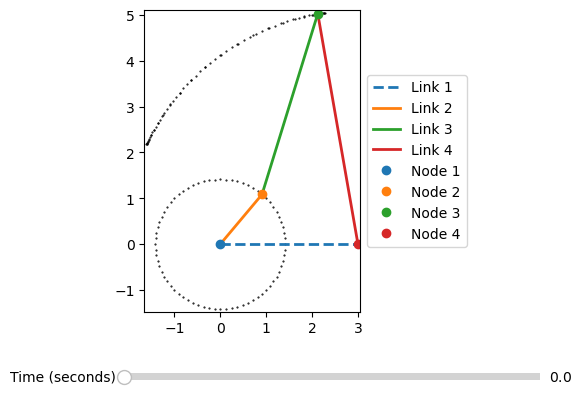

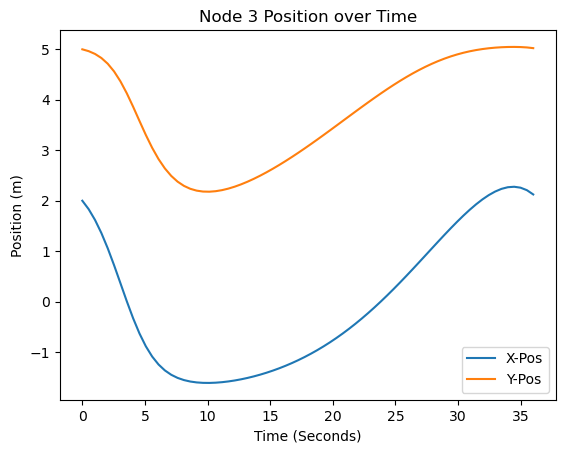

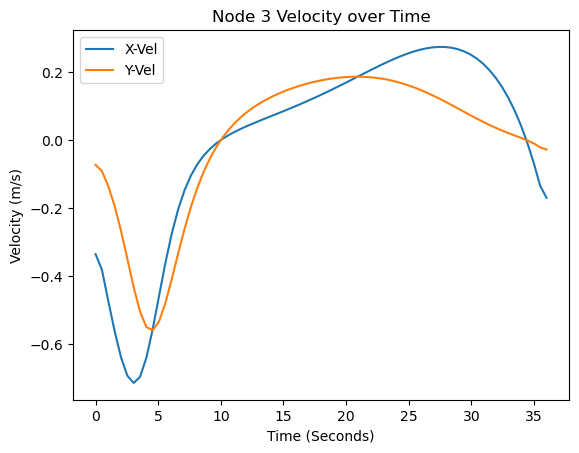

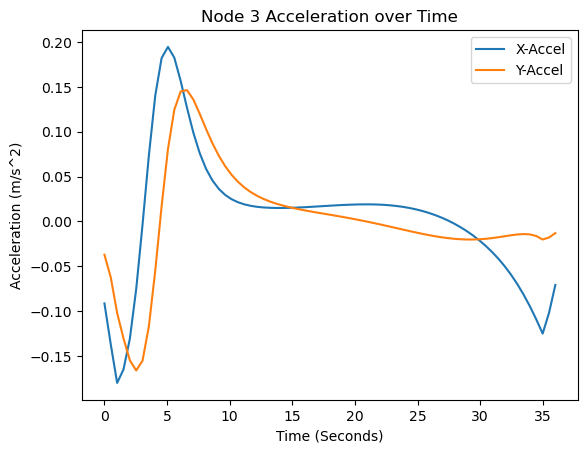

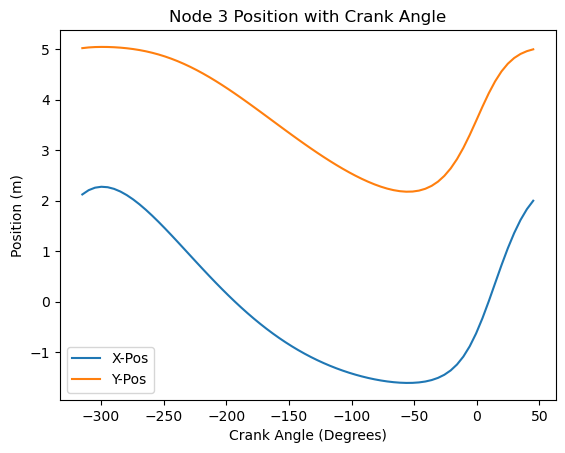

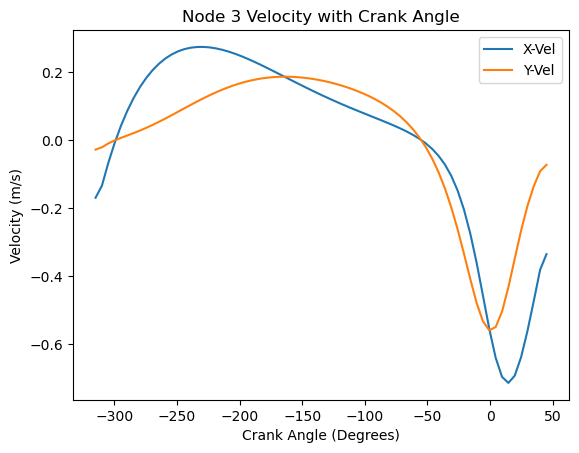

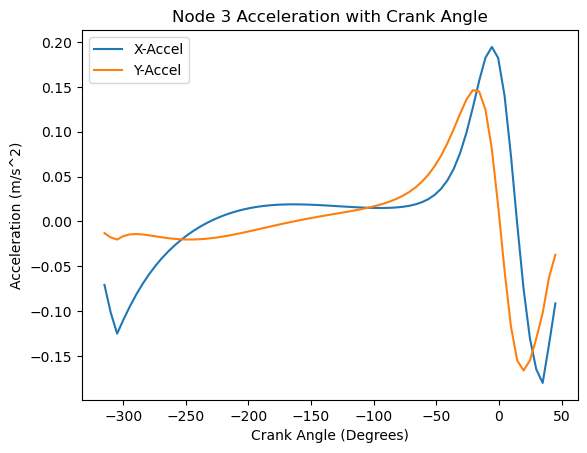

In [3]:
#---------------------------------------------------------
# DO NOT MODIFY THIS FILE
# RUN THIS FILE AS IT IS USING THE RUN BUTTON ON THE LEFT
# THIS MAY TAKE A MINUTE TO RUN
#---------------------------------------------------------


#|Numerical PVA Code|University of Illinois at Urbana-Champaign|
#|ME 370|Created by Brian C. McGuigan for MATLAB adapted by Ali Ibrahim A Albazroun for Python

#Section0:Imports
import numpy as np
#from PVA import PVA

#Section1:Input
# initial_node_positions = np.array([0.0+0.0j,1.0+5.0j,2.0+1.0j,3.0+0.0j]) # Node/Joint Placement
initial_node_positions = np.array([0+0j,1+1j,2+5j,3+0j])
connectivity_matrix = [[0,3],[0,1],[1,2],[2,3]] #Connectivity Matrix
ground_links_idx = [0] #indices of grounded links (index of row in connectivity matrix)
crank_link_idx = 1 # Link with prescribed position over time (input crank)
motor_node_idx = 0 #Node the motor is at.
sliders = [] #Slider constraints #[node index,link 1 index, link 2 index] or [node index,link index, x direction, y direction]
links_with_fixed_angle = [] #Fix link/link angle during rotation. (Must share a node)
rotation_fixed_nodes = [] #Nodes that are fixed so that they cant rotate
slider_friction = [] #Friction at slider constraints

tperiod=36 #total time to run simulation (seconds)
dt=0.5 #time step (seconds)
crank_angular_velocity=-10 #Angular velocity of input crank (deg/sec) -Assumed constant.
             #+(-) angular velocity denotes CCW (CW) rotation

plotting_node_idx = 2 # for plotting the position, velocity, acceleration over time

#call the PVA
n_timesteps,node_positions,velocity,acceleration, link_lengths, crank_angle = PVA(
initial_node_positions,
connectivity_matrix,
ground_links_idx,
crank_link_idx,
motor_node_idx,
sliders,
links_with_fixed_angle,
rotation_fixed_nodes,
tperiod,
dt,
crank_angular_velocity,
plotting_node_idx,
)



# THE DFA CODE BEGINS HERE!

## Section 0: Import libraries

In [4]:
#|Numerical PVA Code|University of Illinois at Urbana-Champaign| 2025 Fall Semester
#|ME 370|Created by Seung Yun ("Leo") Song

import numpy as np
import matplotlib.pyplot as plt
#from PVA import PVA
#from in_lab import*


## Section 1: Input

In [5]:
################### IN LAB ASSIGNMENT: FILL IN/MODIFY SECTION 1 ########################

cmlink = [0.5, 0.5, 0.5, 0.5] #Fractional link distance from 1st node where the center of mass lies

#Defined in the order cmat is defined in the PVA

cmatbody = [[0], [1], [2], [3]] #Defining rigid bodies as a array

#Note that in PVA, each link was defined to be binary. Links modeled with a fixed angle constraint are physically rigid

gconst=9.81 #gravitational constant in m/s^2 (positive)

#If neglecting gravity, gconst = 0.

wdth=0.0254 #Width of each link (meters).
tks=0.003175 #thickness of each link (meters).
den=1180 #Density for each link (kg/m^3).
cmat = connectivity_matrix
tnum = n_timesteps
links = link_lengths
crlink = crank_link_idx
gndlink = ground_links_idx
crangvel = crank_angular_velocity

## Section2: Calculates the mass of each link using the previously defined link lens and the above constant width, thickness, and density

In [6]:
Mlink = np.zeros([len(cmat),1]); #Mass of each binary link

for i in range(len(cmat)):
    Mlink[i] = link_lengths[i]*den*wdth*tks

M = np.zeros([len(cmatbody),1]); #Mass of each rigid body

for i in range(len(cmatbody)):
    if len(cmatbody[i]) == 1: #Body consists of one link
        M[i]=Mlink[cmatbody[i]]; #calculates mass of body i
    else:
        M[i]=sum([Mlink[x] for x in cmatbody[i]]);

## Section 3: Calculate center of mass and moment of inertia for each link and rigid body

In [7]:
################### IN LAB ASSIGNMENT: FILL IN/MODIFY SECTION 3 ########################

r1link = np.zeros([len(cmat),tnum], dtype=np.complex128)
r2link = np.zeros([len(cmat),tnum], dtype=np.complex128)
rcglink = np.zeros([len(cmat),tnum], dtype=np.complex128) #Position of center of mass for link as complex number.

for k in range(tnum): #loops over all timesteps of simulation
    for i in range(len(cmat)): #loops over all links
        nd1ind=cmat[i][0] #node 1 index of link i
        nd2ind=cmat[i][1] #node 2 index of link i
        r2link[i][k]=node_positions[nd2ind][k] #Position of node 2 for link i
        r1link[i][k]=node_positions[nd1ind][k] #Position of node 1 for link i
        
        # rcglink[i][k]= ################## FILL IN LINK CG CALCULATIONS HERE
        rcglink[i][k]=r2link[i][k]*cmlink[i]+r1link[i][k]*(1-cmlink[i])
        
rcg = np.zeros([len(cmatbody),tnum], dtype=np.complex128) #Position of center of mass for each body

for k in range(tnum):
    for i in range(len(cmatbody)):
        if len(cmatbody[i]) == 1:
            rcg[i][k]=rcglink[cmatbody[i][0]][k];
        else:
            rcg[i][k]=sum(Mlink[cmatbody[i]].flatten()*rcglink[cmatbody[i]][:,k])/sum(Mlink[cmatbody[i]])[0]; #Position of center of mass of each body

Ilink = np.zeros([len(cmat),1]); #Moment of Inertia of each binary link

for i in range(len(cmat)):
    Ilink[i]=Mlink[i]*(wdth**2+links[i]**2)/12

I = np.zeros([len(cmatbody),1]) #Moment of inertias for each link. Single column matrix where row i is the moment of inertia of link i

for i in range(len(cmatbody)):
    if len(cmatbody[i]) == 1:
        I[i] = Ilink[cmatbody[i][0]] #moment of inertia of rectangular link through center
    else:
        I[i] = sum(Mlink[cmatbody[i]].flatten() * abs(rcg[i][0]-rcglink[cmatbody[i]][:,0])**2 + Ilink[cmatbody[i]].flatten()) #Parallel Axis Theorem: I = Ic +md^2



## Section4: Calculates theta, omega and alpha of each body

In [8]:
################### IN LAB ASSIGNMENT: FILL IN/MODIFY SECTION 4 ########################

thetalink = np.zeros([len(cmat),tnum]) #allocate angles over all time steps

for k in range(tnum):
    for i in range(len(cmat)):
        thetalink[i][k] = np.angle(node_positions[cmat[i][1]][k] - node_positions[cmat[i][0]][k]) #Calculation of theta for each link IN RADIANS

theta = np.zeros([len(cmatbody),tnum])

for i in range(len(cmatbody)):
    if len(cmatbody[i]) == 1:
        theta[i] = thetalink[cmatbody[i]] #Calculation of theta for each body IN RADIANS
    else:
        theta[i] = thetalink[cmatbody[i][0]] #Choose an arbitrary link - does not matter

omega=np.zeros([len(cmatbody),tnum-1]) #omega for each body in radians/sec

for k in range(tnum-1):
    if k==0:
        omega[:,k] = (thetalink[:,k+1]-thetalink[:,k])/dt
        # omega[:,k]= FILL IN OMEGA CALCULATION #################
    else:
        omega[:,k] = (thetalink[:,k+1]-thetalink[:,k-1])/2/dt
        # omega[:,k]= FILL IN OMEGA CALCULATION #################


#Calculation similar to velocity calculation in PVA


for i in range(len(cmatbody)):
    if cmatbody[i][0] == crlink:
        omega[i] = crangvel*np.pi/180# Fill in omega calculation COMPLETE THIS CODE #########################



alpha=np.zeros([len(cmatbody),tnum-2]) #omega for each body in radians/sec

for k in range(tnum-2):
    if k==0:
        alpha[:,k] = (omega[:,k+1]-omega[:,k])/dt
        # alpha[:,k]= COMPLETE THIS CODE #########################

    else:
        alpha[:,k] = (omega[:,k+1]-omega[:,k-1])/dt/2
        # alpha[:,k]= COMPLETE THIS CODE #########################

#Calculation similar to acceleration calculation in PVA

## Section5: Calculates the linear acceleration of each link's center of mass/gravity by differentiating rcg and then vcg

In [9]:
vcg=np.zeros([len(cmatbody),tnum-1], dtype=np.complex128) #linear velocity for each center of gravity
acg=np.zeros([len(cmatbody),tnum-2], dtype=np.complex128) #linear acceleration for each center of gravity

for k in range(tnum-1):
    if k==0:
        vcg[:,k]=(rcg[:,k+1]-rcg[:,k])/dt
    else:
        vcg[:,k]=(rcg[:,k+1]-rcg[:,k-1])/(2*dt)

#Calculation similar to velocity calculation in PVA


for k in range(tnum-2):
    if k==0:
        acg[:,k]=(vcg[:,k+1]-vcg[:,k])/dt
    else:
        acg[:,k]=(vcg[:,k+1]-vcg[:,k-1])/(2*dt)

#Calculation similar to acceleration calculation in PVA



## Section6: Allocates B, external forces and moving bodies

In [10]:
neqs=3*(len(cmatbody)-len(gndlink)) #Number of equations. Sum of Fx,Fy,Torque for all links except ground.
B=np.zeros([neqs,tnum-2])#Allocate solution vector


##-----Define External Forces here (does not include link weights)-----##

F = [] #F1 as a complex number
body_F = [] #Link Index where F1 Acts
node_F = [] #Node where F1 acts

# If an external force acts on the cg of a body, leave that value of node_F1 as zero.

bodynotgnd = np.arange(0, len(cmatbody))

for i in range(len(gndlink)):
    if bodynotgnd[i] == gndlink[i]:
        bodynotgnd = np.delete(bodynotgnd, i)

## Section7: Fills in link components (Sum Fx,Fy,M) in A,C matrix/vector

In [19]:
################### IN LAB ASSIGNMENT: FILL IN/MODIFY SECTION 7 ########################

for k in range(tnum-2):
    A = np.zeros([neqs,neqs])
    C = np.zeros([neqs,1])

    #

    R12 = node_positions[0][k]-rcglink[1][k]# COMPLETE THE MATRIX AND NECESSARY VARIABLES

    R32 = node_positions[1][k]-rcglink[1][k]# Define position vectors for the torque equations

    R23 = node_positions[1][k]-rcglink[2][k]

    R43 = node_positions[2][k]-rcglink[2][k]

    R34 = node_positions[2][k]-rcglink[3][k]

    R14 = node_positions[3][k]-rcglink[3][k]

    # define A matrix
    A[0,0] = 1
    A[0,2] = 1
    
    A[1, 1] = 1
    A[1, 3] = 1

    A[2, 0] = -R12.imag
    A[2, 1] = R12.real
    A[2, 2] = -R32.imag
    A[2, 3] = R32.real
    A[2, 8] = 1

    A[3, 2] = -1
    A[3, 4] = 1

    A[4, 3] = -1
    A[4, 5] = 1

    A[5, 2] = R23.imag
    A[5, 3] = -R23.real
    A[5, 4] = -R43.imag
    A[5, 5] = R43.real

    A[6, 4] = -1
    A[6, 6] = 1

    A[7, 5] = -1
    A[7, 7] = 1

    A[8, 4] = R34.imag
    A[8, 5] = -R34.real
    A[8, 6] = -R14.imag
    A[8, 7] = R14.real


    for i in range(len(bodynotgnd)):

        C[3*(i+1)-3]= M[i]*acg[i][k].real# COMPLETE THE MATRIX AND NECESSARY VARIABLES

        C[3*(i+1)-2]= M[i]*acg[i][k].imag+M[i]*gconst# Define the C matrix

        C[3*(i+1)-1]= I[i]*alpha[i][k]

        if np.size(F) != 0:
            for jj in range(len(F)):
                if bodynotgnd[i] == body_F[jj]:
                    C[3*(i+1)-3]=C[3*(i+1)-3]-np.real(F[jj])
                    C[3*(i+1)-2]=C[3*(i+1)-2]-np.imag(F[jj])
                    if node_F[jj] != 0:
                        C[3*(i+1)-1]=C[3*(i+1)-1]-(np.real(node_positions[node_F[jj],k]-rcg[body_F[jj],k]))*np.imag(F[jj])+(np.imag(node_positions[node_F[jj],k]-rcg[body_F[jj],k]))*np.real(F[jj])

    B[:,k] = np.linalg.lstsq(A,C)[0].flatten()

C:\Users\13613\AppData\Local\Temp\ipykernel_9628\421672279.py:73: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  B[:,k] = np.linalg.lstsq(A,C)[0].flatten()


## Section 8: Comparison with Principle of Virtual Work

In [ ]:
################### IN LAB ASSIGNMENT: FILL IN/MODIFY SECTION 8 ########################

E=np.zeros([len(cmatbody),tnum-1])

for i in bodynotgnd:
    for k in range(tnum-1):
        E[i,k]=M[i][0]*(abs(vcg[i][k])**2)/2+I[i][0]*(abs(omega[i][k])**2)/2
        # E[i,k]= # COMPLETE THIS PART #####################

E = sum(E)

height_cg = tks/2 # Height of the center of mass of each link # COMPLETE THIS PART #####################
E+=sum(M)*gconst*height_cg

dEdt=np.zeros([tnum-2,1])

for k in range(tnum-2):
    if k==0:
        dEdt[k] = (E[k+1]-E[k])/dt
    else:
        dEdt[k] = (E[k+1]-E[k-1])/(2*dt)




torque = B[8,:]
VWexternal = np.zeros([tnum-2,1])

for k in range(tnum-2):

    VWexternal[k] = torque[k]*omega[crlink][k] # Fill in here

    if np.size(F) != 0:
        for jj in range(len(F)):
            if node_F[jj] == 0:
                VWexternal[k] += F[jj]*vcg[body_F[jj]][k]
                # VWexternal[k] = # COMPLETE THIS PART #####################

            else:
                VWexternal[k] += F[jj]*velocity[node_F[jj]][k]
                # VWexternal[k] = # COMPLETE THIS PART #####################

In [ ]:
################### IN LAB ASSIGNMENT: FILL IN/MODIFY SECTION 8 ########################

E=np.zeros([len(cmatbody),tnum-1])

for i in bodynotgnd:
    for k in range(tnum-1):

        # Comments:
        # we are just sum all the KE PE together  
        Ke_trans=0.5*M[i]*(np.abs(vcg[i,k]**2))
        KE_rotation=0.5*I[i]*(np.abs(omega[i,k]**2))
        PE=gconst*M[i]*np.imag(rcg[i,k])
        
        E[i,k]=Ke_trans+KE_rotation+PE

E = sum(E)

# we don't need this line because we already use imag.rcg instead
# height_cg = # Height of the center of mass of each link # COMPLETE THIS PART #####################
dEdt=np.zeros([tnum-2,1])

for k in range(tnum-2):
    if k==0:
        dEdt[k] = (E[k+1]-E[k])/dt
    else:
        dEdt[k] = (E[k+1]-E[k-1])/(2*dt)

torque = B[8,:]
VWexternal = np.zeros([tnum-2,1])

for k in range(tnum-2):
# vmexternal is only torque*omega 
# this is the motor crank
    crank_body_index=1

    VWexternal[k] = torque[k]*omega[crank_body_index,k]  # Fill in here

    if np.size(F) != 0:
        for jj in range(len(F)):
            # 
            if node_F[jj] == 0:
                #  we need to add force X velocity at mass center
                body_index = body_F[jj]
                # P = F · v_cg
                force_power = np.real(np.conj(F[jj]) * vcg[body_index, k])
                VWexternal[k] = VWexternal[k] + force_power
                #####################

            else:
                node_index = node_F[jj]
                # P = F · v_node
                force_power = np.real(np.conj(F[jj]) * velocity[node_index, k])
                VWexternal[k] = VWexternal[k] + force_power
                # COMPLETE THIS PART #####################

C:\Users\13613\AppData\Local\Temp\ipykernel_9628\497907026.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  E[i,k]=Ke_trans+KE_rotation+PE


## Section 9: Plots

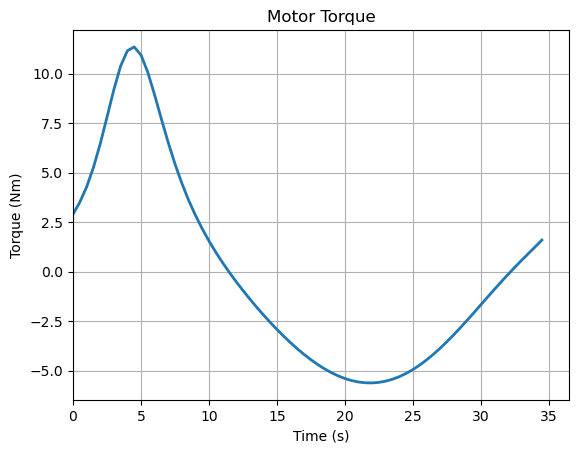

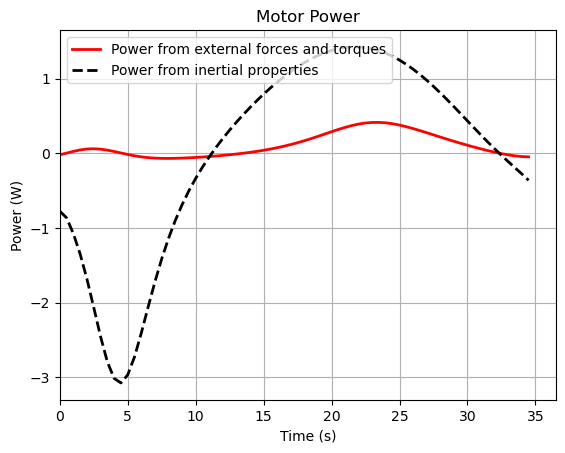

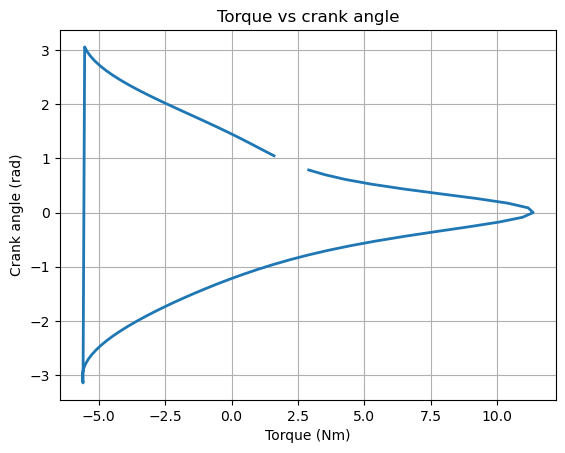

In [20]:
################### IN LAB ASSIGNMENT: FILL IN/MODIFY SECTION 9 ########################

time_plot = np.arange(0, tperiod+dt, dt)
plt.figure()
plt.plot(time_plot[:tnum-2], torque[:tnum-2], linewidth = 2)
plt.title('Motor Torque')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.xlim([0, tperiod+dt])
plt.grid(1)


plt.figure()
plt.plot(time_plot[:tnum-2],VWexternal, color = 'r', linewidth = 2, label = 'Power from external forces and torques')
plt.plot(time_plot[:tnum-2], dEdt, color = 'k', linewidth = 2, linestyle = 'dashed', label = 'Power from inertial properties')
plt.title('Motor Power')
plt.xlabel('Time (s)')
plt.ylabel('Power (W)')
plt.xlim([0, tperiod+dt])
plt.grid(1)
plt.legend(loc='upper left')

# Add the code for plotting torque with crank angle on the x-axis
plt.figure()
plt.plot(torque[:tnum-2],thetalink[crlink][:tnum-2], linewidth = 2)
plt.title('Torque vs crank angle')
plt.ylabel('Crank angle (rad)')
plt.xlabel('Torque (Nm)')
plt.grid(1)

plt.show()

